In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

shark=pd.read_csv('attacks_new.csv')
shark=shark.loc[:,'Case Number':]
shark=shark.drop(['Case Number.1','Case Number.2','Unnamed: 22','Unnamed: 23'],axis=1)

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
#Pull key words out of Activity and put them into new column, Activity_type
act=r'([Ss]urf|[Ss]wim|[Bb]oat|[Ss]pear|[Ff]ish|[Bb]ath|[Ww]ading|[Dd]iving|[Ss]norkeling|[Bb]oard|[Ff]loat|[Rr]ow|[Ww]alking|[Kk]ayak|[Cc]anoe|[Ss]hip|[Ss]ki|[Ff]ell|[Ww]ash|[Tt]read|Unknown)'
shark['Activity_type']=shark['Activity'].str.extract(act)
shark['Activity_type']=shark['Activity_type'].fillna(value='other')

shark['Activity_type']=shark['Activity_type'].str.lower()

In [4]:
#read times into new column
shark['Hour'] = shark['Time'].str.extract(r'(\d+\D\d+)')
shark['Hour'] = shark['Hour'].str.replace(r'(\d+)\D(\d+)',r'\1\2')
shark['Hour'] = pd.to_numeric(shark['Hour'],errors='coerce')
shark['time_cat'] = pd.cut(shark['Hour'], [0,500,800,1100,1400,1700,2100,2400],labels=['Night','Early Morning','Morning','Midday','Afternoon','Evening','night'])
shark['time_cat'] = shark['time_cat'].str.lower()

pattern = r'([Aa]fternoon|[Mm]orning|[Nn]ight|[Ee]arly\s[Mm]orning|[Mm]idday|[Ee]vening)'
shark['time2'] = shark['Time'].str.extract(pattern)
shark['time_cat'] = shark['time_cat'].combine_first(shark['time2'].str.lower())

In [5]:
# with size -> group into ranges, convert meters to feet
# match digits
size_pattern_ft = r"([\d\.]+)(?:')"
size_pattern_m = r'([\d\.]+)(?: ?m)'

# extract based on patterns for feet and meters
shark['size_ft'] = shark['Species'].str.extract(size_pattern_ft)
shark['size_m'] = shark['Species'].str.extract(size_pattern_m)
# convert string to numeric
shark['size_ft'] = pd.to_numeric(shark['size_ft'])
shark['size_m'] = pd.to_numeric(shark['size_m'],errors='coerce') #multiply to convert meters to feet

#combine_first prioritizes first column so meter sizes are only used where ft is NaN
shark['size'] = shark.size_ft.combine_first(shark.size_m*3.3)
# group sizes into categories
shark['size_cat'] = pd.cut(shark['size'], [0,5,10,15,25,400],labels=['0-5','5-10','10-15','15-25','25+'])

# remove 25+ entry because it is incorrectly reading millimeters
shark[shark['size_cat'] == '25+'] = np.nan

shark['size_cat'].value_counts()

5-10     858
0-5      569
10-15    346
15-25    171
25+        0
Name: size_cat, dtype: int64

In [6]:
# shark species can have 1 or 2 names
# pattern selects a word with 3 or more letters and a group with a word followed by shark
species_pattern = r'([a-zA-Z]{3,})?\s*([a-zA-Z]{3,}\s*shark)'
# extract based on the pattern into a dataframe with two columns
spec_df = shark['Species'].str.extract(species_pattern)
# some species only have one word in addition to shark
spec_col = spec_df[1]
# if there is a match for the first group, concatenate the columns together
spec_col[spec_df[0].isnull() == False] = spec_df[0].str.cat(spec_df[1], sep='')
spec_col = spec_col.str.lower()
# Consolidate names for same shark species
spec_col[spec_col == 'zambesi shark'] = 'tiger shark'
# remove small shark because it is not a species
spec_col[spec_col == 'small shark'] = np.nan

shark['shark_species'] = spec_col

In [8]:
shark.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,original order,Full Location,Latitude,Longitude,Activity_type,Hour,time_cat,time2,size_ft,size_m,size,size_cat,shark_species
0,2018.06.25,25-Jun-18,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,"No injury to occupant, outrigger canoe and pad...",N,18h00,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,6303.0,"Oceanside, San Diego County, California, USA",33.195870,-117.379483,other,1800.0,evening,NaN,NaN,NaN,NaN,NaN,white shark
1,2018.06.18,18-Jun-18,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,AdysonÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ...,F,11,Minor injury to left thigh,N,14h00 -15h00,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,6302.0,"St. Simon Island, Glynn County, Georgia, USA",NaN,NaN,other,1400.0,midday,NaN,NaN,NaN,NaN,NaN,NaN
2,2018.06.09,9-Jun-18,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,48,Injury to left lower leg from surfboard skeg,N,07h45,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,6301.0,"Habush, Oahu, Hawaii, USA",NaN,NaN,surf,745.0,early morning,NaN,NaN,NaN,NaN,NaN,NaN
3,2018.06.08,8-Jun-18,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,NaN,Minor injury to lower leg,N,NaN,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,6300.0,"Arrawarra Headland, New South Wales, AUSTRALIA",-30.060426,153.201685,surf,NaN,NaN,NaN,NaN,2.0,6.6,5-10,NaN
4,2018.06.04,4-Jun-18,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,NaN,Lacerations to leg & hand shark PROVOKED INCIDENT,N,NaN,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,6299.0,"La Ticla, Colima, MEXICO",NaN,NaN,diving,NaN,NaN,NaN,NaN,3.0,9.9,5-10,tiger shark


In [9]:
shark['size_cat'].value_counts()

5-10     858
0-5      569
10-15    346
15-25    171
25+        0
Name: size_cat, dtype: int64

In [10]:
shark['Activity_type'].value_counts()

surf          1194
other         1157
swim          1096
fish           706
diving         536
spear          416
board          207
bath           191
wading         169
snorkeling      95
fell            88
boat            87
ship            61
kayak           57
float           50
tread           38
row             37
ski             35
canoe           27
walking         26
wash            23
unknown          5
Name: Activity_type, dtype: int64

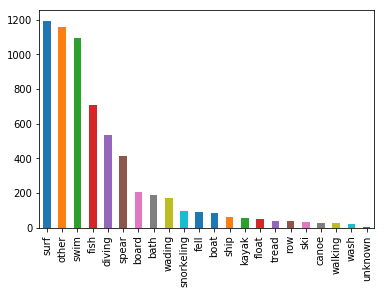

In [11]:
shark['Activity_type'].value_counts().plot(kind='bar')
plt.show()

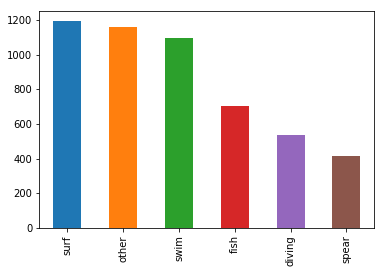

In [38]:
shark['Activity_type'].value_counts()[:6].plot(kind='bar')
plt.show()

In [41]:
shark.groupby(['Country'])['Activity_type'].value_counts().nlargest(25)

Country           Activity_type
USA               surf             675
                  swim             379
                  other            344
AUSTRALIA         surf             245
                  other            235
                  swim             201
USA               fish             194
AUSTRALIA         fish             172
                  diving           160
SOUTH AFRICA      surf             135
USA               diving           133
                  wading           114
SOUTH AFRICA      swim             106
USA               board            103
SOUTH AFRICA      other             96
AUSTRALIA         spear             89
USA               spear             80
SOUTH AFRICA      fish              67
AUSTRALIA         bath              66
SOUTH AFRICA      spear             55
BAHAMAS           spear             40
PAPUA NEW GUINEA  other             38
BRAZIL            surf              37
                  swim              35
USA               kayak         

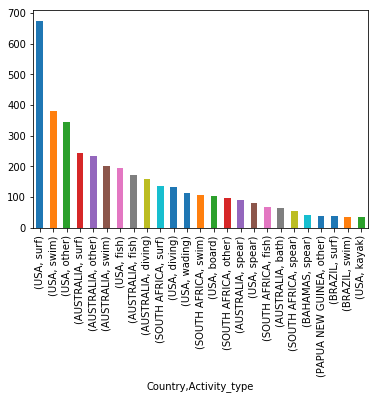

In [42]:
group=shark.groupby(['Country'])['Activity_type'].value_counts().nlargest(25)
group.plot.bar()
plt.show()

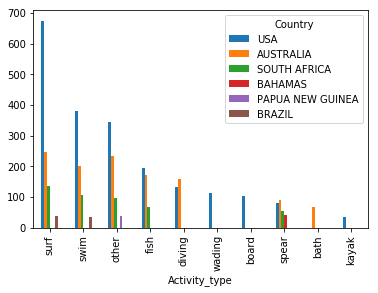

In [43]:
shark.groupby('Country').Activity_type.value_counts().nlargest(25).unstack(0).plot.bar()
plt.show()

In [18]:
shark[shark.Country=='USA'].Activity_type.value_counts()

surf          675
swim          379
other         344
fish          194
diving        133
wading        114
board         103
spear          80
kayak          34
float          30
snorkeling     29
bath           27
walking        20
boat           15
fell           15
ski            14
tread           9
canoe           5
wash            3
row             3
ship            2
unknown         1
Name: Activity_type, dtype: int64

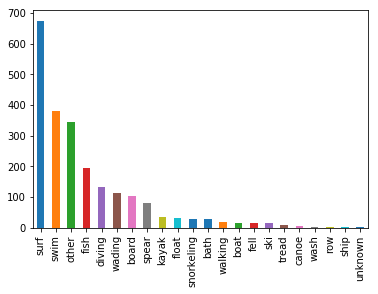

In [44]:
shark[shark.Country=='USA'].Activity_type.value_counts().plot.bar()
plt.show()

In [20]:
shark[shark.Country=='AUSTRALIA'].Activity_type.value_counts()

surf          245
other         235
swim          201
fish          172
diving        160
spear          89
bath           66
fell           25
board          22
snorkeling     22
wading         20
row            20
boat           14
kayak          12
tread           7
ship            7
canoe           6
ski             4
walking         3
float           3
wash            3
unknown         2
Name: Activity_type, dtype: int64

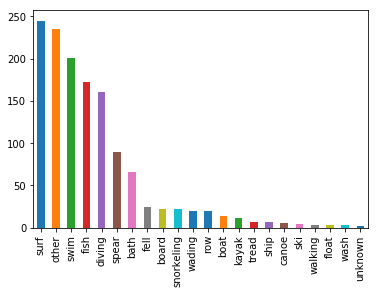

In [45]:
shark[shark.Country=='AUSTRALIA'].Activity_type.value_counts().plot.bar()
plt.show()

In [23]:
shark[shark.Country=='SOUTH AFRICA'].Activity_type.value_counts()

surf          135
swim          106
other          96
fish           67
spear          55
diving         31
board          20
tread          19
wading         11
ski             9
bath            5
float           5
kayak           5
snorkeling      4
ship            4
unknown         1
row             1
wash            1
walking         1
boat            1
canoe           1
Name: Activity_type, dtype: int64

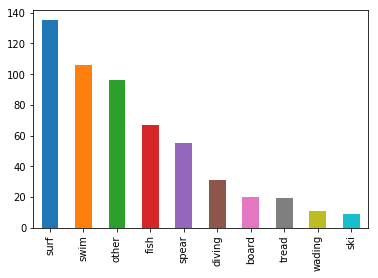

In [46]:
shark[shark.Country=='SOUTH AFRICA'].Activity_type.value_counts().nlargest(10).plot.bar()
plt.show()

In [12]:
shark.groupby(['Hour'])['Activity_type'].value_counts().nlargest(25)

Hour    Activity_type
1100.0  surf             43
1400.0  surf             33
1630.0  surf             32
1500.0  surf             31
1600.0  surf             30
1700.0  surf             30
1500.0  swim             28
1730.0  surf             28
1200.0  spear            24
1800.0  surf             24
1530.0  surf             23
1130.0  surf             22
1200.0  surf             22
        swim             22
1800.0  swim             22
1300.0  surf             21
1630.0  swim             21
1000.0  surf             20
1330.0  surf             20
900.0   surf             19
930.0   surf             19
1430.0  surf             18
        swim             18
1030.0  surf             17
1600.0  other            17
Name: Activity_type, dtype: int64

In [13]:
shark.groupby(['time_cat'])['Activity_type'].value_counts().nlargest(25)

time_cat       Activity_type
afternoon      surf             270
morning        surf             213
afternoon      swim             199
midday         surf             189
evening        surf             129
midday         swim             120
afternoon      other             98
evening        swim              97
early morning  surf              79
morning        swim              76
midday         spear             66
morning        diving            64
afternoon      diving            62
midday         diving            57
morning        other             53
midday         other             52
afternoon      board             51
               spear             51
morning        spear             51
afternoon      wading            43
evening        other             40
afternoon      fish              39
morning        fish              36
night          fish              36
midday         wading            34
Name: Activity_type, dtype: int64

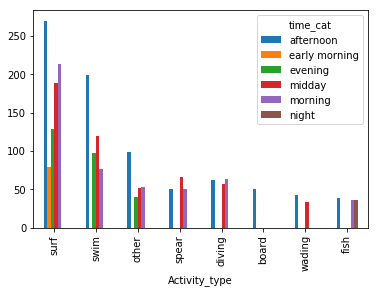

In [15]:
shark.groupby('time_cat').Activity_type.value_counts().nlargest(25).unstack(0).plot.bar()
plt.show()

In [50]:
shark.groupby(['size_cat'])['Activity_type'].value_counts().nlargest(25)

ValueError: operands could not be broadcast together with shape (5,) (4,)

In [20]:
shark['shark_species'].value_counts().nlargest(25)

white shark              621
tiger shark              286
bull shark               171
bronzewhaler shark        60
blacktip shark            56
nurse shark               50
mako shark                47
wobbegong shark           46
raggedtooth shark         43
spinner shark             43
greynurse shark           40
hammerhead shark          37
lemon shark               37
blue shark                37
oceanicwhitetip shark     25
sandtiger shark           20
greyreef shark            17
caribbeanreef shark       15
sand shark                15
reef shark                14
dusky shark               11
blacktipreef shark        10
sevengill shark            9
carpet shark               7
gill shark                 7
Name: shark_species, dtype: int64

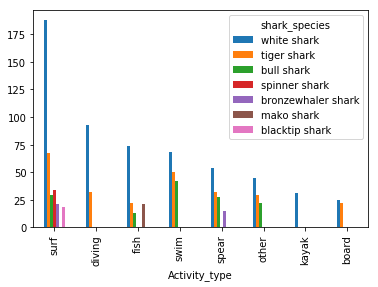

In [21]:
shark.groupby('shark_species').Activity_type.value_counts().nlargest(25).unstack(0).plot.bar()
plt.show()

In [11]:
shark.groupby('shark_species').time_cat.value_counts().nlargest(50)

shark_species          time_cat     
white shark            afternoon        130
                       morning          130
                       midday           106
bull shark             afternoon         49
tiger shark            afternoon         49
                       morning           43
                       midday            41
white shark            early morning     35
                       evening           35
bull shark             morning           28
tiger shark            evening           23
bull shark             midday            16
tiger shark            early morning     16
blacktip shark         afternoon         15
bull shark             evening           15
bronzewhaler shark     midday            13
spinner shark          midday            13
bronzewhaler shark     afternoon         11
spinner shark          morning           11
blacktip shark         morning           10
nurse shark            afternoon         10
raggedtooth shark      evening         

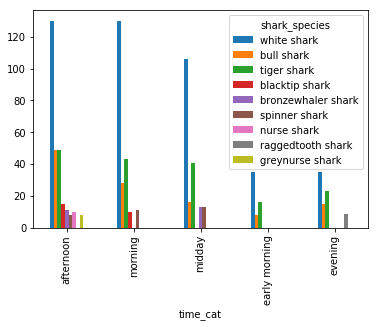

In [13]:
shark.groupby('shark_species').time_cat.value_counts().nlargest(25).unstack(0).plot.bar()

In [14]:
shark['time_cat'].value_counts()

afternoon        924
midday           641
morning          621
evening          375
early morning    172
night            123
Name: time_cat, dtype: int64

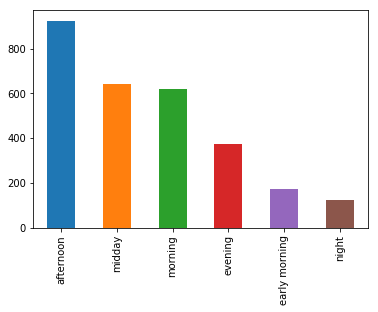

In [15]:
shark['time_cat'].value_counts().plot.bar()

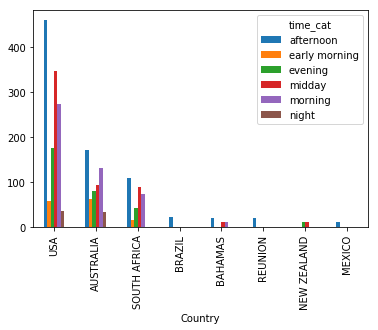

In [20]:
shark.groupby('time_cat').Country.value_counts().nlargest(25).unstack(0).plot.bar()

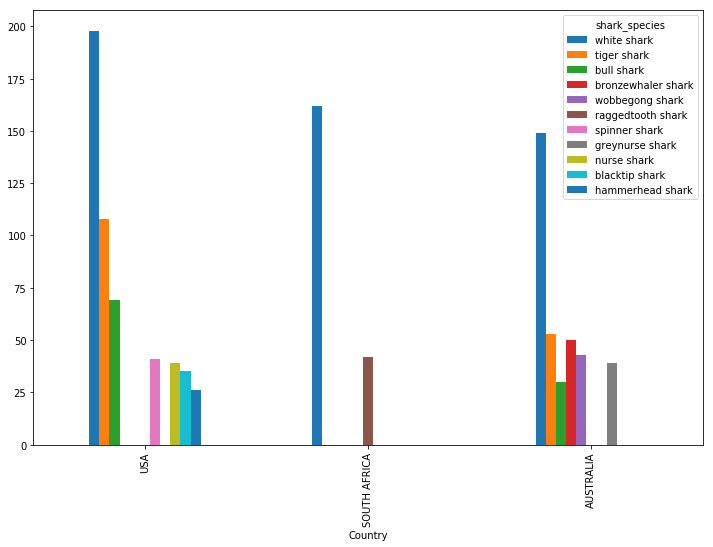

In [49]:
shark.groupby('shark_species').Country.value_counts().nlargest(15).unstack(0).plot.bar(figsize=[12,8])
plt.show()
